## Spam or ham

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Read the csv file

In [2]:
df=pd.read_csv('spam.csv',encoding='latin-1')[['v1','v2']]
df.columns=['label','message']

#### Understand your data

In [3]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

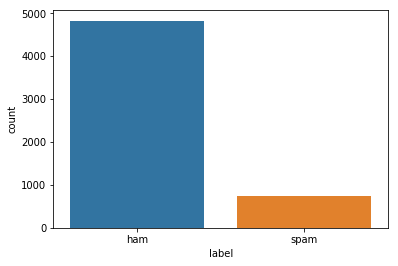

In [4]:
sns.countplot(data=df,x='label')

#### Data preprocessing
* __Remove punctuation,stop words and apply stemming__

In [5]:
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer

def process_data(text):
    text=text.lower()
    text=''.join([t for t in text if t not in string.punctuation])
    text=[t for t in text.split() if t not in stopwords.words('english')]
    st=Stemmer()
    text=[st.stem(t) for t in text]
    return text        

In [6]:
df['message'][:10].apply(process_data)

0    [go, jurong, point, crazi, avail, bugi, n, gre...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entri, 2, wkli, comp, win, fa, cup, fin...
3        [u, dun, say, earli, hor, u, c, alreadi, say]
4    [nah, dont, think, goe, usf, live, around, tho...
5    [freemsg, hey, darl, 3, week, word, back, id, ...
6    [even, brother, like, speak, treat, like, aid,...
7    [per, request, mell, mell, oru, minnaminungint...
8    [winner, valu, network, custom, select, receiv...
9    [mobil, 11, month, u, r, entitl, updat, latest...
Name: message, dtype: object

#### Create a document term matrix to be fed into the model
* __Use tfidf to get the vector__

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer()
data = tfidfv.fit_transform(df['message'])

#### Create a data pipeline involving vectorization and classification

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
spam_filter = Pipeline([
    ('vectorizer', TfidfVectorizer()), # messages to weighted TFIDF score
    ('classifier', MultinomialNB())                    # train on TFIDF vectors with Naive Bayes
])

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2)

In [11]:
spam_filter.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_id...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

#### Check the performance of the model on test data

In [12]:
predictions=spam_filter.predict(x_test)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print 'Below is the summary report'
print '***************************'
print classification_report(y_test, predictions)
print 'Below is the confusion matrix'
print '*****************************'
print confusion_matrix(y_test,predictions)

Below is the summary report
***************************
             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       956
       spam       1.00      0.69      0.82       159

avg / total       0.96      0.96      0.95      1115

Below is the confusion matrix
*****************************
[[956   0]
 [ 49 110]]


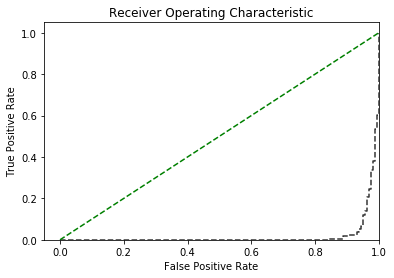

In [14]:
from sklearn.svm.libsvm import predict_proba
from sklearn.metrics import roc_curve

proba=spam_filter.predict_proba(x_test)[:,1]
fpr,tpr,threshold=roc_curve(y_test, proba,pos_label='ham')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'k--', alpha=0.8)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Check how well the model classifies spam messages

In [15]:
def detect_spam(s):
    return spam_filter.predict([s])[0]

In [16]:
detect_spam('Our records indicate your Pension is under performing to see higher growth and up to 25% cash release reply PENSION for a free review. To opt out reply STOP')

u'spam'

In [17]:
detect_spam('Your cash-balance is currently 500 pounds - to maximize your cash-in now, send COLLECT to 83600.')

u'spam'

In [18]:
detect_spam('Free entry in 2 a wkly comp to win FA Cup final')

u'spam'